In [1]:
# from easyimages import EasyImageList


In [2]:
# ChestNTE= EasyImageList.from_folder('/Users/Erik/Desktop/unetchest/data/LungSegmentation/CXR_png')
# ChestNTE.symlink_images()
# ChestNTE.html(sample=800, size=44)
# len(ChestNTE)


In [4]:
# ChestPTE= EasyImageList.from_folder('/Users/Erik/Desktop/unetchest/data/LungSegmentation/masks')
# ChestPTE.symlink_images()
# ChestPTE.html(sample=700, size=44)
# len(ChestPTE)

In [89]:
import os
import glob
import re

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

In [90]:
TAB_DATA_PATH = "../unetchest/data/LungSegmentation/ClinicalReadings/"
IMGS_PATH = '../unetchest/data/LungSegmentation/CXR_png/'
MASKS_PATH = "../unetchest/data/LungSegmentation/masks/"
TEST_IMG_PATH = "../unetchest/data/LungSegmentation/test/"
IMG_SIZE = 128

In [91]:
# def get_df_with_patients_info(path=TAB_DATA_PATH):

tab_data_txt = os.listdir(TAB_DATA_PATH)
ids = ' '.join(map(str, tab_data_txt)).replace(".txt", "").split()
tabular_data = []

for idx, one_diagnosis in zip(ids, tab_data_txt):
#         print(idx, one_diagnosis)
    with open(TAB_DATA_PATH + one_diagnosis) as f:
        info = []
        for line in f:

            line = line.lower().strip()

            if "mal" in line and "normal" not in line and len(line) < 20:


                line = line.replace(",", "")
                line = line.replace(" ", "")

                match = re.match(r"([a-z]+)([0-9]+)", line, re.I)
                if match:
                    line = " ".join(match.groups())

                sex, age = zip(line.split())
                info.extend([list(sex), list(age)])
                continue

            info.append([line])

        info = [i for i in info if i != ['']]
        info.insert(0, [idx])
        info[3:] = [[i[0] for i in info[3:]]]
        info = [i[0] for i in info]

        tabular_data.append(info)
            
pd.DataFrame(tabular_data, 
            columns=["Id", "Sex", "Age", "Diagnosis"]).to_csv("raw_patients_info.csv",
                                                            index=False)
            
# get_df_with_patients_info()

In [92]:
df = pd.read_csv("raw_patients_info.csv")
df

,Id,Sex,Age,Diagnosis
0,CHNCXR_0099_0,female,26,normal
1,CHNCXR_0635_1,male,65,bilateral ptb
2,CHNCXR_0320_0,male,38,normal
3,CHNCXR_0571_1,female,36,right ptb
4,CHNCXR_0534_1,male,21,right ptb
...,...,...,...,...
795,CHNCXR_0231_0,male,33,normal
796,CHNCXR_0274_0,female,64,normal
797,MCUCXR_0094_0,patient's sex: f,patient's age: 065y,normal
798,MCUCXR_0150_1,patient's sex: m,patient's age: 032y,extensive infiltrates bilaterally with large c...


In [93]:
df['Sex'].value_counts()

male                449
female              210
patient's sex: f     74
patient's sex: m     63
femal                 3
patient's sex: o      1
Name: Sex, dtype: int64

In [94]:
df['Sex']= df['Sex'].replace({"patient's sex: f": "female",
                                     "patient's sex: m": "male",
                                     "femal": "female",
                                     "patient's sex: o": "male"})
df["Sex"].value_counts()

male      513
female    287
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Gender Count')

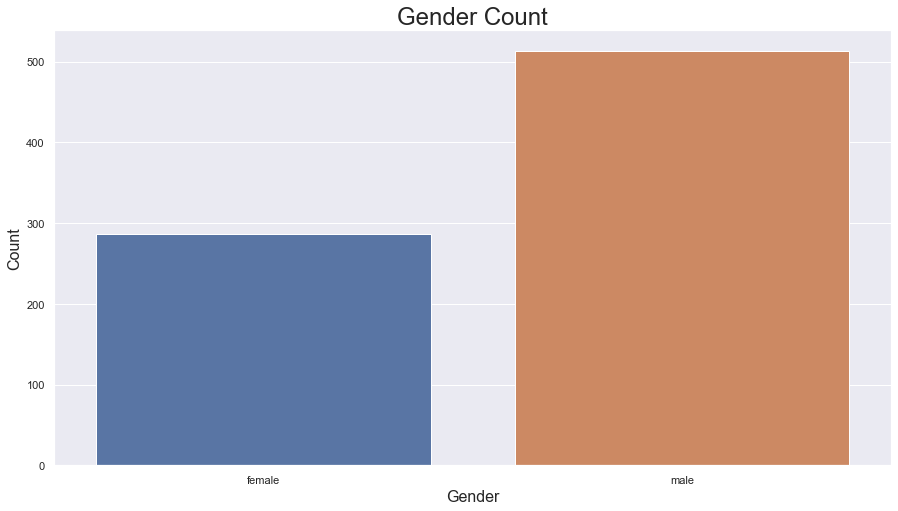

In [95]:
plt.figure(figsize=(15,8))
sns.countplot(data=df,  x= 'Sex')
plt.xlabel("Gender", size=16)
plt.ylabel("Count", size=16)
plt.title("Gender Count", size=24)




In [96]:
df['Age'].value_counts()

28                     33
25                     32
24                     29
23                     25
39                     25
                       ..
patient's age: 018y     1
patient's age: 042y     1
patient's age: 085y     1
patient's age: 051y     1
patient's age: 017y     1
Name: Age, Length: 137, dtype: int64

In [97]:
age_list = df["Age"].apply(lambda line: re.findall(r'([1-9]\d+|[1-9])', line)).values
df['Age']=[int(age[0])for age in age_list]
df['Age'].value_counts()

28    35
25    35
24    31
32    29
30    29
      ..
9      1
81     1
82     1
84     1
88     1
Name: Age, Length: 82, dtype: int64

Text(0.5, 1.0, 'Age Distributions')

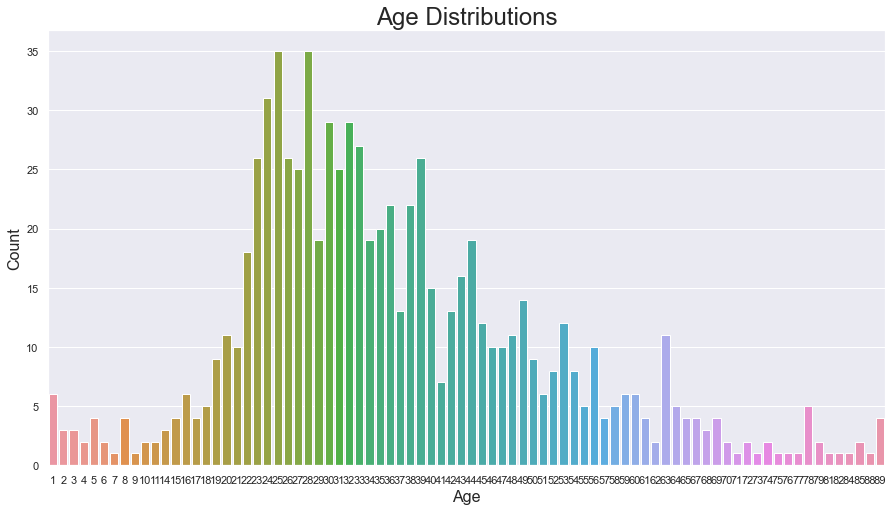

In [98]:
plt.figure(figsize=(15,8))
sns.countplot(data=df,  x= 'Age')
plt.xlabel("Age", size=16)
plt.ylabel("Count", size=16)
plt.title("Age Distributions", size=24)

Text(0.5, 1.0, 'Distribution of Sex and Age')

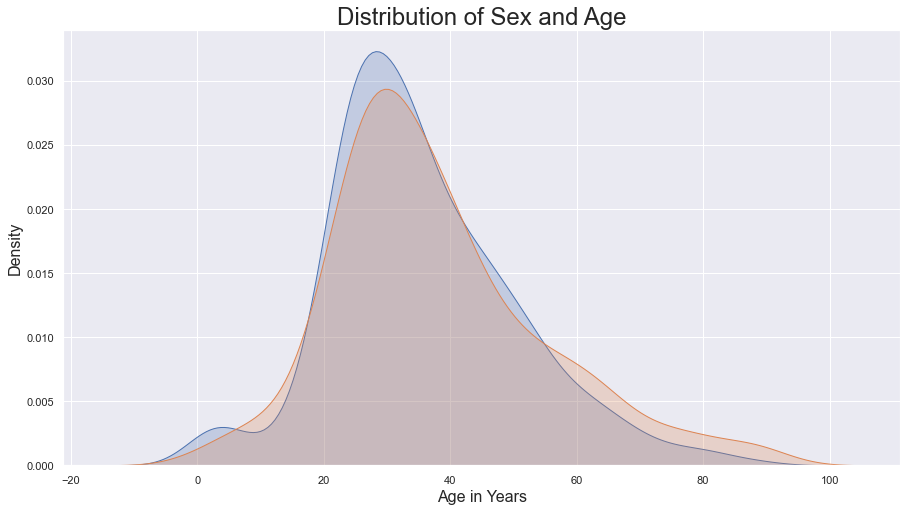

In [104]:
plt.figure(figsize=(15,8))
sns.kdeplot(df.loc[raw_df['Sex'] == 'male', 'Age'], label = 'Male',shade=True)
sns.kdeplot(df.loc[raw_df['Sex'] == 'female', 'Age'], label = 'Female',shade=True)
plt.xlabel("Age in Years", size=16)
plt.ylabel("Density", size=16)
plt.title("Distribution of Sex and Age", size=24)



In [107]:
df['Diagnosis'].value_counts()

normal                                                                    405
bilateral ptb                                                              61
right ptb                                                                  45
ptb in the right upper field                                               27
left ptb                                                                   21
                                                                         ... 
large right pleural effusion, positive tst, tb pleural effusion likely      1
secondary ptb in the right upper field                                      1
right secondary ptb  with bilateral  pleurisy                               1
smear positive, active tb lul apex                                          1
lul infiltrate, ? small areas of cavitation, imp: active tb                 1
Name: Diagnosis, Length: 130, dtype: int64